# Film Cooling Amalysis
This analysis injects calculates the liquid film cooling, and gas film cooling 

## Importing Libraries

In [2]:
from unit_conversions import *
from util import *
import numpy as np
from math import sqrt, log, exp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [11]:
water_density = 1000
ethanol_density = 789

volume_percent = .7
mass_ethanol = ethanol_density*volume_percent
mass_water = water_density*(1-volume_percent)

mass_percent = mass_ethanol/(mass_ethanol+mass_water)
print(mass_percent)

0.6480112636395635


## Physical Properties
Combusion properties of the hot gas mixture. Variable use `_g` to denote combusion gas properties

In [ ]:
# Value                    | Units       | Description              | Source
#--------------------------+-------------+--------------------------+-----
γ_g = 1.1603               # N/A         | Specific heat ratio      | RPA w/ of 1.6
R_g = 358.8                # J/kg-K      | Gas constant             | RPA w/ of 1.6
T_g = 3272                 # K           | Combustion temperature   | RPA w/ of 1.6
Pr_g = 0.6785              # N/A         | Gas Prandtl's number     | RPA w/ of 1.6
Cp_g = γ_g*R_g/(γ_g-1)     # J/kg-K      | Isobaric specific heat   | Math
print(Cp_g)
M_g = 23.1729              # g/mol       | Molecular weight         | RPA w/ of 1.6
μ_g = 1.0707e-4            # Pa-s        | Dynamic viscosity        | RPA w/ of 1.6
P_ch = psia2Pa(420)        # Pa          | Chamber stagnation press | Use defined

2712.973967459325


Ethanol coolant properties. Variables use `_l` and `_v` to denoate liquid and vapor ethanol properties respectively.

In [65]:
# Value                    | Units       | Description                             | Source
#--------------------------+-------------+-----------------------------------------+---------------------------------------------
# LIQUID ETHANOL           #             |                                         |
Cp_l = 4000                # J/kg-K      | Specific heat at constant pressure      | https://www.engineeringtoolbox.com/specific-heat-capacity-ethanol-Cp-Cv-isobaric-isochoric-ethyl-alcohol-d_2030.html
ρ_l = 700                  # kg/m^3      | Density                                 | https://www.engineeringtoolbox.com/ethanol-ethyl-alcohol-density-specific-weight-temperature-pressure-d_2028.html
μ_l = 0.00025              # Pa-s        | Dynamic viscosity @ 125 C               | https://www.engineeringtoolbox.com/ethanol-dynamic-kinematic-viscosity-temperature-pressure-d_2071.html
M_l = 46.068               # g/mol       | Molecular weight                        | Periodic table
                           #             |                                         |
# PHASE TRANSITION         #             |                                         |
T_sat = C2K(205)          # K           | Boiling temperature at chamber pressure | https://www.engineeringtoolbox.com/ethanol-ethyl-alcohol-properties-C2H6O-d_2027.html
H_vap = 488387.236814      # J/kg        | Enthalpy of vaporization                | https://webbook.nist.gov/cgi/cbook.cgi?ID=C64175&Mask=4
                           #             |                                         |
# GASEOUS ETHANOL          #             |                                         |
R_v = 180.5                # J/kg-K      | Ethanol gas constant                    | https://www.engineeringtoolbox.com/ethanol-ethyl-alcohol-properties-C2H6O-d_2027.html
Cp_v = 3500                # J/kg-K      | Specific heat at constant pressure      | https://www.engineeringtoolbox.com/ethanol-ethyl-alcohol-density-specific-weight-temperature-pressure-d_2028.html
ρ_v = P_ch/(T_sat*R_v)    # kg/m^3      | Density                                 | Ideal gas law
μ_v = 16e-6                # Pa-s        | Dynamic viscosity                       | https://www.engineeringtoolbox.com/ethanol-dynamic-kinematic-viscosity-temperature-pressure-d_2071.html

## Engine Geometry
An 80% parabolic nozzle is chosen. The constants for this section are coopied from the results of the calculations done in `regen_cooling.py`. In this cordinate system, the variable `z` denotes the axial direction, with `z=0` being at the nozzle throat.

In [66]:
# Enginer profile transition points
z_0 = -0.09133870736781699
z_1 = -0.04022570186862804
z_2 = -0.011342655641154435
z_3 = -0.004596598413407203
z_4 = 0
z_5 = 0.0007086456603122631
z_6 = 0.01760980229449234

# Engine shape constants
r_c = 0.02261356668429169
r_t = 0.0047673584494975696
r_2 = 0.044934043208391436
theta_conv = 40
a_para = 0.06363174621142852
b_para = 0.0016876851878647346
c_para = 0.0017959677527373717

# Engine contour functions
R_2 = lambda z: np.sqrt(r_2 ** 2 - (z - z_1)**2) + (r_c-r_2)
R_3 = lambda z: -tand(theta_conv) * (z - z_3) + R_4(z_3)
R_4 = lambda z: -np.sqrt((1.5 * r_t) ** 2 - z ** 2) + 2.5 * r_t
R_5 = lambda z: -np.sqrt((0.382 * r_t) ** 2 - z ** 2) + 1.382 * r_t
R_6 = lambda z: a_para*np.sqrt(z+b_para)+c_para

# Piecewise engine function
def R_engine(z):
    return np.piecewise(
        z,
        [z < z_1, (z >= z_1)& (z < z_2), (z >= z_2) & (z < z_3), (z >= z_3) & (z < z_4),(z >= z_4) & (z < z_5), z>=z_5],
        [r_c, R_2, R_3, R_4, R_5,R_6]
    )

The engine contour is plotting to confirm accuracy. It should be a continous and differential profile.

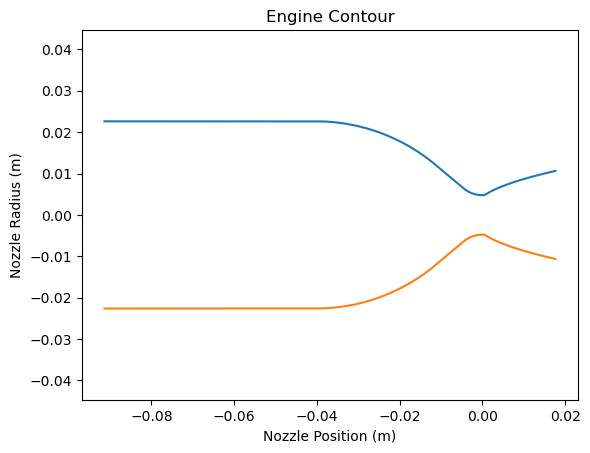

In [67]:
z_list = np.linspace(z_0, z_6, 1000)
plt.plot(z_list, R_engine(z_list))
plt.plot(z_list, -R_engine(z_list))
plt.axis('equal')
plt.xlabel("Nozzle Position (m)")
plt.ylabel("Nozzle Radius (m)")
plt.title("Engine Contour")
plt.show()

Now with the chamber geometry defined with `R_engine()`, the thermodynamic properties of the combusion gasses will be calculated using isentropic relations and the area mach equation.  

In [68]:
# THERMODYNAMIC PROPERTIES
#-----------------------------------------------------------------------------------------------------------------------
A_t = r2area(r_t)
A_list = r2area(R_engine(z_list))
area_mach_eq = lambda M,A: A / A_t - pow(2 / (γ_g + 1) * (1 + (γ_g - 1) / 2 * M ** 2),
                                                            (γ_g + 1) / (2 * (γ_g - 1))) / M
M_list = np.array([
    fsolve(
        area_mach_eq,
        0.1 if x < z_4 else 2,
        args=(A)
    )[0]
    for A, x in zip(A_list, z_list)
])

# Find gas properties using isentropic relations
recovery_factor = Pr_g**0.33
T_g_list = T_g*pow(1+(γ_g-1)/2*M_list**2,-1)
Taw_list = T_g*(1+recovery_factor*(γ_g-1)/2*M_list**2)/(1+(γ_g-1)/2*M_list**2)

T_comp = Taw_list/T_g_list
P_list = P_ch*pow(1+(γ_g-1)/2*M_list**2,-γ_g/(γ_g-1))
ρ_ch = P_ch/(R_g*T_g)
ρ_list = ρ_ch*pow(1+(γ_g-1)/2*M_list**2,-γ_g/(γ_g-1))
Vel_list = np.sqrt(γ_g*R_g*T_g_list)*M_list

## Critical Film Flowrate
The mass flow rate per circumfrence, `Γ`, has a critical threshold `Γ_cr` that should not be exceeded. Flowrates above this value causes large scale waves in the film that result in droplet shear that mass loss to be 2-4 time the predicted evaporation rate.

In [12]:
Γ_cr = 1.01e5 * μ_v**2/μ_l
print(f"The critical flow rate is {Γ_cr:.3f} kg/s-m")
print(f"This corresponds to a mass flow rate of {Γ_cr*(2*pi*r_c):.3f} kg/s at the chamber circumfrence")
if μ_v/μ_l < 0.3: print(f"This relationship is not valid! Outside of bounds of correlation. Viscosity ratio {μ_v/μ_l}") # Viscosity ratio needs to be >0.3 

NameError: name 'μ_v' is not defined

The value for `ṁ_cr` is quite small! This may be an issue... While the corelation is well outside the >0.3 threshold, it is still used in the paper so it be wise to not completely ignore it.
##  Simple Liquid Film Cooled Length

In [89]:
T_l_in = 290 # K initial cooling temp

# Flow rates
ṁ_ch =  0.12607 # kg/s
ṁ_fraction = .1           
ṁ_film = ṁ_ch * ṁ_fraction # kg/s
Γ = ṁ_film/(2*pi*r_c)   # kg/m-s

# Check if the critical threshold has been past. Since the criteria of >0.3 is not met, it not completelu applicable but worth checking
if(Γ>Γ_cr): print("The critical flow rate is being exceeded")

λ_star = H_vap + Cp_l*(T_sat-T_l_in)  # J/kg
ΔT = (T_g - T_sat)
K_m = (M_g/M_l)**0.6 if M_l < M_g else (M_g/M_l)**0.35
H = Cp_g * ΔT * K_m / λ_star
h_ratio = log(1 + H)/H
Vel_g = ṁ_ch/(ρ_ch * r2area(r_c))
Re_D = ρ_ch * Vel_g * (2*r_c)/μ_g
St_o = 0.023 * Re_D**-0.2 * Pr_g**-0.6  # AAssumes fully develoved flow L_c > 5*D which is not met
G_ch = ρ_ch * Vel_g
Vel_l = 1.5 # m/s
G_mean = G_ch*(T_g/avg(T_g,T_sat))*(Vel_g-Vel_l)/Vel_g
print(f"h_o = {G_mean*Cp_g*St_o}")
L_c = Γ*λ_star/(G_mean * Cp_g * ΔT * St_o * (h_ratio))  
print(L_c)


h_o = 1230.0070763069505
0.07929826461799153


## Complete Liquid Film Cooling Formulation
This now includes non-fully developed flows, radiation, turbulence, etc

### Radiation

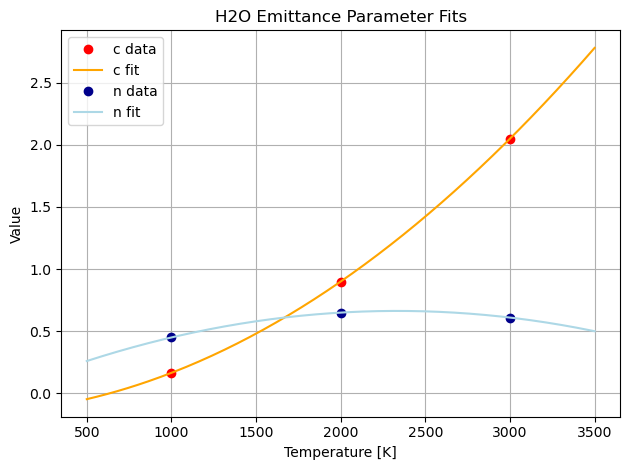

In [ ]:
T_test = np.linspace(500,3500,200)
# Tabular data for H2O emmitance
T_tabular_H2O = np.array([1000, 2000, 3000])    # K
c_tabular_H2O = np.array([.165, 0.9, 2.05])    # atm-m
n_tabular_H2O = np.array([.45, .65, .61])      # ul
c_H2O = np.poly1d(np.polyfit(T_tabular_H2O, c_tabular_H2O, 2)) # Fit a polynomial to the data
n_H2O = np.poly1d(np.polyfit(T_tabular_H2O, n_tabular_H2O, 2)) # Fit a polynomial to the data

# Plot
plt.plot(T_tabular_H2O, c_tabular_H2O, 'ro', label='c data')
plt.plot(T_test, c_H2O(T_test), color='orange', label='c fit')
plt.plot(T_tabular_H2O, n_tabular_H2O, 'o', color='darkblue', label='n data')
plt.plot(T_test, n_H2O(T_test), color='lightblue', label='n fit')
plt.xlabel('Temperature [K]')
plt.ylabel('Value')
plt.title('H2O Emittance Parameter Fits')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

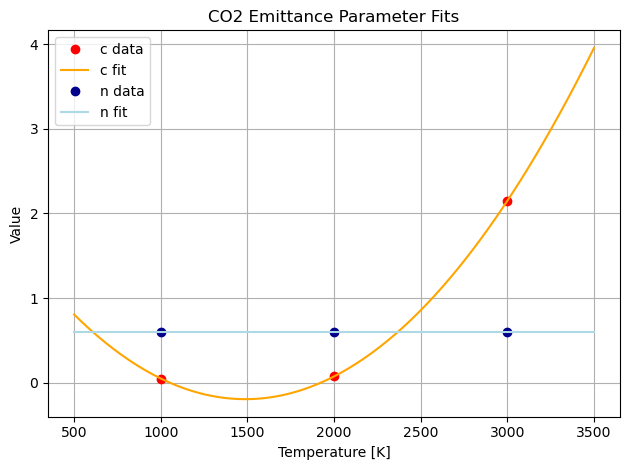

In [87]:
# Tabular data for CO2 emmitance
T_tabular_CO2 = np.array([1000, 2000, 3000])    # K
c_tabular_CO2 = np.array([.05, 0.075, 2.15])    # atm-m
n_tabular_CO2 = np.array([.6, .6, .6])          # ul
c_CO2 = np.poly1d(np.polyfit(T_tabular_CO2, c_tabular_CO2, 2)) # Fit a polynomial to the data
n_CO2 = np.poly1d(np.polyfit(T_tabular_CO2, n_tabular_CO2, 2)) # Fit a polynomial to the data

# Plot
plt.plot(T_tabular_CO2, c_tabular_CO2, 'ro', label='c data')
plt.plot(T_test, c_CO2(T_test), color='orange', label='c fit')
plt.plot(T_tabular_CO2, n_tabular_CO2, 'o', color='darkblue', label='n data')
plt.plot(T_test, n_CO2(T_test), color='lightblue', label='n fit')
plt.xlabel('Temperature [K]')
plt.ylabel('Value')
plt.title('CO2 Emittance Parameter Fits')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def Emittance_g(P,L_eff,T,N_w,N_c):
    """
    P:
    """
    ρ_opt = P*L_eff         # Optical density
    P_CO2 = P*N_c/(N_c+N_w) # Partial pressure of CO2
    P_H2O = P*N_c/(N_c+N_w) # Partial pressure of H2O
    ρ_CO2 = P_CO2*L_eff     # Optical density of CO2
    ρ_H2O = P_H2O*L_eff     # Optical density of H2O

    # Emmitance for H2O
    ε_f_H2O = 0.825
    C_1 = 0.26 + 0.74*exp(-2.5*ρ_H2O)
    C_2 = 0.75 + 0.31*exp(-10*ρ_H2O)
    K_p_H2O = 1+C_1*(1-exp((1-P*(1+N_w))/C_2))
    ε_H2O = ε_f_H2O * (1+(ρ_H2O/c_H2O(T))**-n_H2O(T))**(-1/n_H2O(T))
    
    # Emmitance for CO2
    ε_f_CO2 = 0.231
    m = 100*ρ_CO2
    K_p_CO2 = 10**(0.036*ρ_CO2**-.433*(1+(2*log10(P))**-m)**(-1/m))
    ε_CO2 = ε_f_CO2 * (1+(ρ_CO2/c_CO2(T))**-n_CO2(T))**(-1/n_CO2(T))

    # A correction Δε is needed to account for overlaps in the two specta. It is found through the flowwing correlation:
    n = 5.5*(1+(1.09*ρ_opt)**-3.33)**(-1/3.33)
    K_x = 1 - abs(2*N_w/(N_w+N_c)-1)**n
    Δε = 0.0551*K_x*(1-exp(-4*ρ_opt))*(1-exp(-12.5*ρ_opt))

    ε_g = K_p_H2O*ε_H2O + K_p_CO2*ε_CO2 - Δε
    return ε_g

In [ ]:
z=0
e_t = .13
K_t = 1 + 4*e_t
Γ_z = Γ
while Γ_z > 0:  
    z_e = 3.53*D*(1+(z/(3.53*D))**-1.2)**-(1/1.2)
    Re_z = G_z * z_e/μ_g
    C_f_z = 0.0592 * Re_z**-.2
    St_o_z = 1/2 * C_f_z * Pr_g**-0.6
    G_z = G_ch*(T_g/avg(T_g,T_sat))*(Vel_g-Vel_l)/Vel_g
    h_o_z = K_t * G_z*Cp_g*St_o_z
    


## Hutzel Comparison
Yikes! That is terrible film cooling length. Maybe something is really wrong with my code? Let's compare with the method in Hutzel to see if they are similar

In [71]:
η_c = 0.5
H_film =Cp_v*(T_g - T_sat)/(Cp_l*(T_sat-T_l_in)+H_vap)
Vel_d = Vel_g*.01
a = 2 * Vel_d/Vel_g * .011
b = (Vel_g/Vel_d) - 1
A_film = ṁ_film/(G_ch * (1/η_c) * (H_film/(a*(1+b**(Cp_v/Cp_g)))))
L_c_Hutzel = A_film/(2*pi*r_c)
print(L_c_Hutzel)

2.1509647774864864e-06


In [72]:
StRatio =   

SyntaxError: invalid syntax (3065711665.py, line 1)